In [1]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import spacy
nlp = spacy.load("en", disable=['ner', 'parser'])
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import re
import numpy as np
import pandas as pd
from pprint import pprint
import datetime
import pickle
import math
from sklearn.preprocessing import normalize
import rake
import summa

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
from matplotlib import rcParams


# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

from summa import keywords
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])
smart_stop = open('smart_stoplist.txt', 'r').read().strip().split('\n')
stop_words.extend(smart_stop)
stop_words = sorted(list(set(stop_words)))
pprint(stop_words)

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/tuor369/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['a',
 "a's",
 'able',
 'about',
 'above',
 'according',
 'accordingly',
 'across',
 'actually',
 'after',
 'afterwards',
 'again',
 'against',
 'ain',
 "ain't",
 'all',
 'allow',
 'allows',
 'almost',
 'alone',
 'along',
 'already',
 'also',
 'although',
 'always',
 'am',
 'among',
 'amongst',
 'an',
 'and',
 'another',
 'any',
 'anybody',
 'anyhow',
 'anyone',
 'anything',
 'anyway',
 'anyways',
 'anywhere',
 'apart',
 'appear',
 'appreciate',
 'appropriate',
 'are',
 'aren',
 "aren't",
 'around',
 'as',
 'aside',
 'ask',
 'asking',
 'associated',
 'at',
 'available',
 'away',
 'awfully',
 'b',
 'be',
 'became',
 'because',
 'become',
 'becomes',
 'becoming',
 'been',
 'before',
 'beforehand',
 'behind',
 'being',
 'believe',
 'below',
 'beside',
 'besides',
 'best',
 'better',
 'between',
 'beyond',
 'both',
 'brief',
 'but',
 'by',
 'c',
 "c'mon",
 "c's",
 'came',
 'can',
 "can't",
 'cannot',
 'cant',
 'cause',
 'causes',
 'certain',
 'certainly',
 'changes',
 'clearly',
 'co',
 'c

In [3]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True, max_len=20))
        
def remove_stopwords(texts):
    return [[word for word in doc if word not in stop_words] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out# text = lemmas(text)


def lemmas(text, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    doc = nlp(text)
    return ' '.join([token.lemma_ for token in doc if token.pos_ in allowed_postags])

In [4]:
db = pickle.load(open('db.p', 'rb'))
len(db)

538

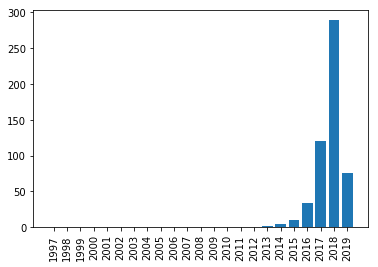

In [5]:
arxiv_texts = [v['summary'] for v in db.values()]
dates = [datetime.datetime.strptime(v['published'], '%Y-%m-%dT%H:%M:%SZ') for v in db.values()]
datetexts = sorted(zip(arxiv_texts, dates), key=lambda x: x[1])
datetextchunks = [[k for k in datetexts if k[1].year == i] for i in range(min(dates).year, max(dates).year + 1)]
plt.bar(range(min(dates).year, max(dates).year + 1), [len(k) for k in datetextchunks])
plt.xticks(range(min(dates).year, max(dates).year + 1), rotation=90)
plt.savefig('year_freq.png')
plt.show()

In [6]:
date_30_days_ago = datetime.datetime.now() - datetime.timedelta(days=30)
recent_arxiv_texts = [k[0] for k in datetexts if (k[1] > date_30_days_ago)]
len(recent_arxiv_texts)

24

In [7]:
rake_object = rake.Rake('smart_stoplist.txt', 5, 3, 4)
text = ' '.join(arxiv_texts)
keywords = rake_object.run(text)

In [8]:
keywords = [(w, s) for w, s in keywords if len(w.split()) > 1]
df = pd.DataFrame(keywords, columns =['Key Phrase', 'Score']) 
df.to_html('rake_keyphrase.html')  
df[:10]  

,Key Phrase,Score
0,deep neural networks,7.460102
1,convolutional neural networks,7.451786
2,deep neural network,7.181331
3,convolutional neural network,7.173015
4,deep learning algorithms,7.099065
5,deep learning models,7.042191
6,deep learning systems,6.937526
7,adversarial machine learning,6.890582
8,machine learning algorithms,6.837481
9,experimental results show,6.808140


/home/tuor369/bin/anaconda3/envs/arxivsanity/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


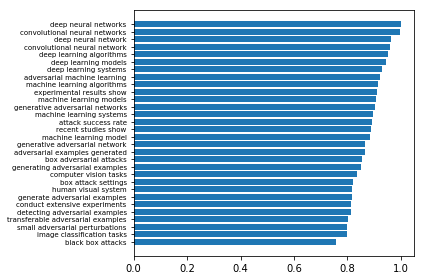

In [9]:
kw = keywords[:30]
kw.reverse()
scores = np.array([t[1] for t in kw])
scores /= max(scores)
plt.barh(range(30), scores)
plt.yticks(range(30), labels=[tw[0] for tw in kw], fontsize=7)
plt.axes().set_aspect('auto')
plt.tight_layout()
plt.savefig('rake_global.pdf')
plt.show()

In [10]:
text = ' '.join(arxiv_texts)
splittext = text.split()
text = ' '.join([word for word in splittext if word not in stop_words])
text = lemmas(text)
kw = summa.keywords.keywords(text, ratio=0.3, scores=True)
kw = [(w, s) for w, s in kw if len(w.split()) > 1 and len(w.split()) < 5]

In [11]:
df = pd.DataFrame(kw, columns =['Key Phrase', 'Score']) 
df.to_html('textrank_keyphrase.html')  
df[:10]  

,Key Phrase,Score
0,vulnerable adversarial example,0.151374
1,attacker restrict,0.127700
2,adversary access underlying,0.096097
3,existence robust,0.093194
4,train subset dataset,0.091792
5,variety medical imaging,0.086475
6,machine learning,0.085530
7,robustness reduce,0.077347
8,input output mapping,0.064875
9,conditional generative,0.064064


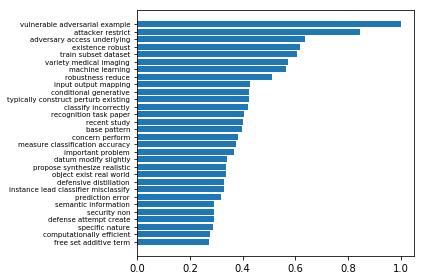

In [12]:
kw = kw[:30]
kw.reverse()
scores = np.array([t[1] for t in kw])
scores /= max(scores)
plt.barh(range(30), scores)
plt.yticks(range(30), labels=[tw[0] for tw in kw], fontsize=7)
plt.axes().set_aspect('auto')
plt.tight_layout()
plt.savefig('textrank_global.pdf')
plt.show()

In [280]:
best_score = -1000
data_words = list(sent_to_words(recent_arxiv_texts))
data_words_nostops = remove_stopwords(data_words)
data_lemmatized = lemmatization(data_words_nostops, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
data_lemmatized = [' '.join(k) for k in data_lemmatized]
counts = CountVectorizer(ngram_range=(2, 3))
counts.fit(data_lemmatized)
id2word = {v:k for k, v in counts.vocabulary_.items()}
x = counts.transform(data_lemmatized)
rows, cols = x.nonzero()
vals = [x[r, c] for r, c in zip(rows, cols)]
uniqrows = np.unique(rows)
corpus = [[(k, v) for i, k, v in zip(rows, cols, vals) if i == n] for n in uniqrows]
for i in range(3, 20):
    
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                               id2word=id2word,
                                               num_topics=i,
                                               random_state=100,
                                               update_every=1,
                                               chunksize=100,
                                               passes=10,
                                               alpha='auto',
                                               per_word_topics=True)
    id2word = gensim.corpora.Dictionary.from_corpus(corpus, id2word)

    coherence_model_lda = CoherenceModel(model=lda_model, corpus=corpus, dictionary=id2word, coherence='u_mass')
    coherence_lda = coherence_model_lda.get_coherence()
    if coherence_lda > best_score:
        best_model = lda_model
        best_score = coherence_lda
        best_num = i
    print('%s: Coherence Score: %s' % (i, coherence_lda))


3: Coherence Score: -13.195083151656979
4: Coherence Score: -11.056779847815957
5: Coherence Score: -11.18141318755293
6: Coherence Score: -11.021763029871593
7: Coherence Score: -10.496844158401686
8: Coherence Score: -9.208875093015966
9: Coherence Score: -8.869869170552539
10: Coherence Score: -6.257513693484442
11: Coherence Score: -8.490255332358558
12: Coherence Score: -6.756171903323447
13: Coherence Score: -7.397578075959686
14: Coherence Score: -4.158542242163993
15: Coherence Score: -6.914632928289783
16: Coherence Score: -5.832479295887194
17: Coherence Score: -5.049814967375863
18: Coherence Score: -7.634368642127247
19: Coherence Score: -6.226384958331937


In [281]:
id2word = gensim.corpora.Dictionary.from_corpus(corpus, id2word)
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(best_model, corpus, id2word)
pyLDAvis.save_html(vis, 'recent_lda.html')
vis

/home/tuor369/bin/anaconda3/envs/arxivsanity/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
10     0.201173 -0.077377       1        1  15.117862
5     -0.151310 -0.141063       2        1  15.041886
1     -0.030185  0.177280       3        1  11.914069
0     -0.014098  0.026472       4        1   8.465635
8      0.001607  0.005885       5        1   8.420048
3     -0.006801  0.006362       6        1   6.070714
9      0.000995  0.001789       7        1   5.429797
4     -0.001558 -0.000108       8        1   5.063429
6     -0.002223  0.008474       9        1   5.063257
11    -0.003705 -0.001665      10        1   4.835054
12     0.001606 -0.000050      11        1   3.827489
2      0.001509 -0.003231      12        1   3.735936
7      0.001339 -0.001298      13        1   3.644628
13     0.001652 -0.001469      14        1   3.370188, topic_info=     Category       Freq                                Term      Total  \
62    Default  13.000000                 adversarial example  13.000000   
2278  Default   2.000000                            bit flip   2.000000   
1287  Default   3.000000            base adversarial example   3.000000   
2792  Default   2.000000                 reinforcement learn   2.000000   
1184  Default   4.000000                    base adversarial   4.000000   
801   Default   5.000000            adversarial perturbation   5.000000   
1432  Default   2.000000                        number query   2.000000   
989   Default   4.000000                        latent space   4.000000   
265   Default   5.000000                           state art   5.000000   
376   Default   4.000000                           black box   4.000000   
859   Default   3.000000                adversarial training   3.000000   
1183  Default   3.000000                   perturbation base   3.000000   
3648  Default   1.000000                      saliency model   1.000000   
3248  Default   1.000000              regionally homogeneous   1.000000   
2863  Default   1.000000                         risk averse   1.000000   
3424  Default   1.000000                    iterative attack   1.000000   
417   Default   5.000000                         input image   5.000000   
2473  Default   2.000000              adversarial robustness   2.000000   
2487  Default   2.000000                        weight prune   2.000000   
1580  Default   2.000000                      annotate image   2.000000   
1421  Default   2.000000                       decision base   2.000000   
1504  Default   2.000000                decision base attack   2.000000   
1422  Default   2.000000                         base attack   2.000000   
952   Default   2.000000                      datum manifold   2.000000   
2634  Default   3.000000                 adversarial network   3.000000   
2     Default   8.000000                      neural network   8.000000   
411   Default   4.000000                       paper propose   4.000000   
1687  Default   1.000000                  robust adversarial   1.000000   
3042  Default   2.000000                       feature space   2.000000   
409   Default   7.000000                  adversarial attack   7.000000   
...       ...        ...                                 ...        ...   
2139  Topic14   0.692329                 common perturbation   1.161656   
2128  Topic14   0.358559                critical application   0.823533   
2143  Topic14   0.358544                  research benchmark   0.823556   
2175  Topic14   0.358554                        work network   0.823618   
2240  Topic14   0.358487     adversarial defense substantial   0.823536   
2209  Topic14   0.358485          recent robustness research   0.823591   
2231  Topic14   0.358449              afterward discover way   0.823549   
2205  Topic14   0.358458          classifi robustness common   0.823590   
2162  Topic14   0.358455                        discover way   0.823597   
2129  Topic14   0.

In [13]:
data_words = list(sent_to_words(arxiv_texts))
data_words_nostops = remove_stopwords(data_words)
data_lemmatized = lemmatization(data_words_nostops, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
data_lemmatized = [' '.join(k) for k in data_lemmatized]
counts = CountVectorizer(ngram_range=(2, 3))
counts.fit(data_lemmatized)
id2word = {v:k for k, v in counts.vocabulary_.items()}
x = counts.transform(data_lemmatized)
rows, cols = x.nonzero()
vals = [x[r, c] for r, c in zip(rows, cols)]
uniqrows = np.unique(rows)
corpus = [[(k, v) for i, k, v in zip(rows, cols, vals) if i == n] for n in uniqrows]
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)


In [236]:
x = lda_model.get_topics()
words = x.sum(axis=0)
idxs = np.argsort(words)
# scores = words[idxs]
topwords = [(id2word[i], words[i]) for i in idxs]
kw = topwords[-30:]
scores = np.array([t[1] for t in kw])

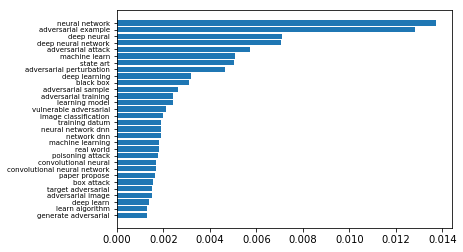

In [237]:
plt.barh(range(30), scores)
plt.yticks(range(30), labels=[tw[0] for tw in kw], fontsize=7)
plt.axes().set_aspect('auto')
plt.savefig('lda_global.pdf')
plt.show()

In [238]:
kw = sorted(topwords, key=lambda x: x[1], reverse=True)[:150]
df = pd.DataFrame(kw, columns =['Key Phrase', 'Score']) 
df.to_html('lda_keyphrase.html')  
df[:10]

,Key Phrase,Score
0,neural network,0.013712
1,adversarial example,0.012844
2,deep neural,0.007116
3,deep neural network,0.007071
4,adversarial attack,0.005745
5,machine learn,0.005062
6,state art,0.005025
7,adversarial perturbation,0.004671
8,deep learning,0.003189
9,black box,0.003089


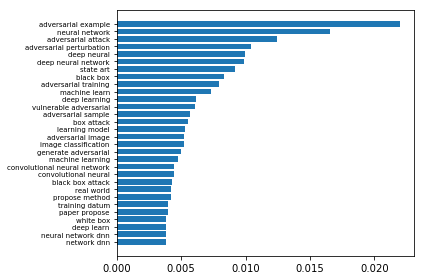

In [179]:
tfidf = TfidfVectorizer(ngram_range=(2, 3), norm='l2')
tfidf.fit(data_lemmatized)
id2word = {v:k for k, v in tfidf.vocabulary_.items()}
x = tfidf.transform(data_lemmatized).toarray()
words = x.mean(axis=0)
idxs = np.argsort(words)

topwords = [(id2word[i], words[i]) for i in idxs if ' ' in id2word[i]]

plt.barh(range(0, len(topwords[-30:])*4, 4), [t[1] for t in topwords[-30:]], height=3)
plt.yticks(range(0, len(topwords[-30:])*4, 4), labels=[tw[0] for tw in topwords[-30:]], fontsize=7)
plt.axes().set_aspect('auto')
plt.savefig('tfidf_global.pdf')
plt.show()

In [180]:
kw = sorted(topwords, key=lambda x: x[1], reverse=True)[:150]
df = pd.DataFrame(kw, columns =['Key Phrase', 'Score']) 
df.to_html('tfidf_keyphrase.html')  
df[:10]

,Key Phrase,Score
0,adversarial example,0.021981
1,neural network,0.016551
2,adversarial attack,0.012425
3,adversarial perturbation,0.010420
4,deep neural,0.009973
5,deep neural network,0.009867
6,state art,0.009138
7,black box,0.008294
8,adversarial training,0.007960
9,machine learn,0.007280


In [ ]:
rcParams.update({'figure.autolayout': False})
datetextchunks = [[k for k in datetexts if k[1].year == i] for i in range(2013, 2020)]
topwords = []
for ik, dtc in enumerate(datetextchunks):
    arxiv_texts_ = [k[0] for k in dtc]
    data_words = list(sent_to_words(arxiv_texts_))
    data_words = remove_stopwords(data_words)
    data_lemmatized = lemmatization(data_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
    data_lemmatized = [' '.join(t) for t in data_lemmatized]
    tfidf = TfidfVectorizer(ngram_range=(2, 3))
    tfidf.fit(data_lemmatized)
    id2word = {v:k for k, v in tfidf.vocabulary_.items()}
    x = tfidf.transform(data_lemmatized).toarray()
    words = x.mean(axis=0)
    idxs = np.argsort(words)
    ids = idxs[-30:]
    scores = words[ids]
    topwords.append([(id2word[i], words[i]) for i in ids])
f, axarr = plt.subplots(2, 4, figsize=(30,20))
datetextchunks = [[k for k in datetexts if k[1].year == i] for i in range(min(dates).year, max(dates).year + 1)]
freq = list([len(d) for d in datetextchunks])
daterange = range(min(dates).year, max(dates).year + 1)
axarr[0][0].bar(daterange, freq, color='y')
axarr[0][0].set_xticks(daterange)
axarr[0][0].set_xticklabels([str(k) for k in daterange], rotation=60)
axarr[0][0].set_title('Document Frequency per Year')
axarr[0][0].set_aspect('auto')
axarr[0][0].spines['top'].set_visible(False)
axarr[0][0].spines['right'].set_visible(False)
axarr[0][0].spines['bottom'].set_visible(False)
axarr[0][0].spines['left'].set_visible(False)

for i in range(2013, 2016):
    axarr[0][i-2012].barh(range(0, len(topwords[0])*4, 4), [t[1] for t in topwords[i-2013]], height=3, color='y')
    axarr[0][i-2012].set_yticks(range(0, len(topwords[i-2013])*4, 4))
    axarr[0][i-2012].set_yticklabels([tw[0] for tw in topwords[i-2013]], fontsize=12)
    axarr[0][i-2012].set_aspect('auto')
    axarr[0][i-2012].set_title(str(i))
    axarr[0][i-2012].set_xlabel('Top Average TFIDFs')
    axarr[0][i-2012].spines['top'].set_visible(False)
    axarr[0][i-2012].spines['right'].set_visible(False)
    axarr[0][i-2012].spines['bottom'].set_visible(False)
    axarr[0][i-2012].spines['left'].set_visible(False)
    
for i in range(2016, 2020):
    axarr[1][i-2016].barh(range(0, len(topwords[0])*4, 4), [t[1] for t in topwords[i-2013]], height=3, color='y')
    axarr[1][i-2016].set_yticks(range(0, len(topwords[i-2013])*4, 4))
    axarr[1][i-2016].set_yticklabels([tw[0] for tw in topwords[i-2013]], fontsize=12)
    axarr[1][i-2016].set_aspect('auto')
    axarr[1][i-2016].set_title(str(i))
    axarr[1][i-2016].set_xlabel('Top Average TFIDFs')
    axarr[1][i-2016].spines['top'].set_visible(False)
    axarr[1][i-2016].spines['right'].set_visible(False)
    axarr[1][i-2016].spines['bottom'].set_visible(False)
    axarr[1][i-2016].spines['left'].set_visible(False)

plt.savefig('tfidf_time.pdf')
plt.show()

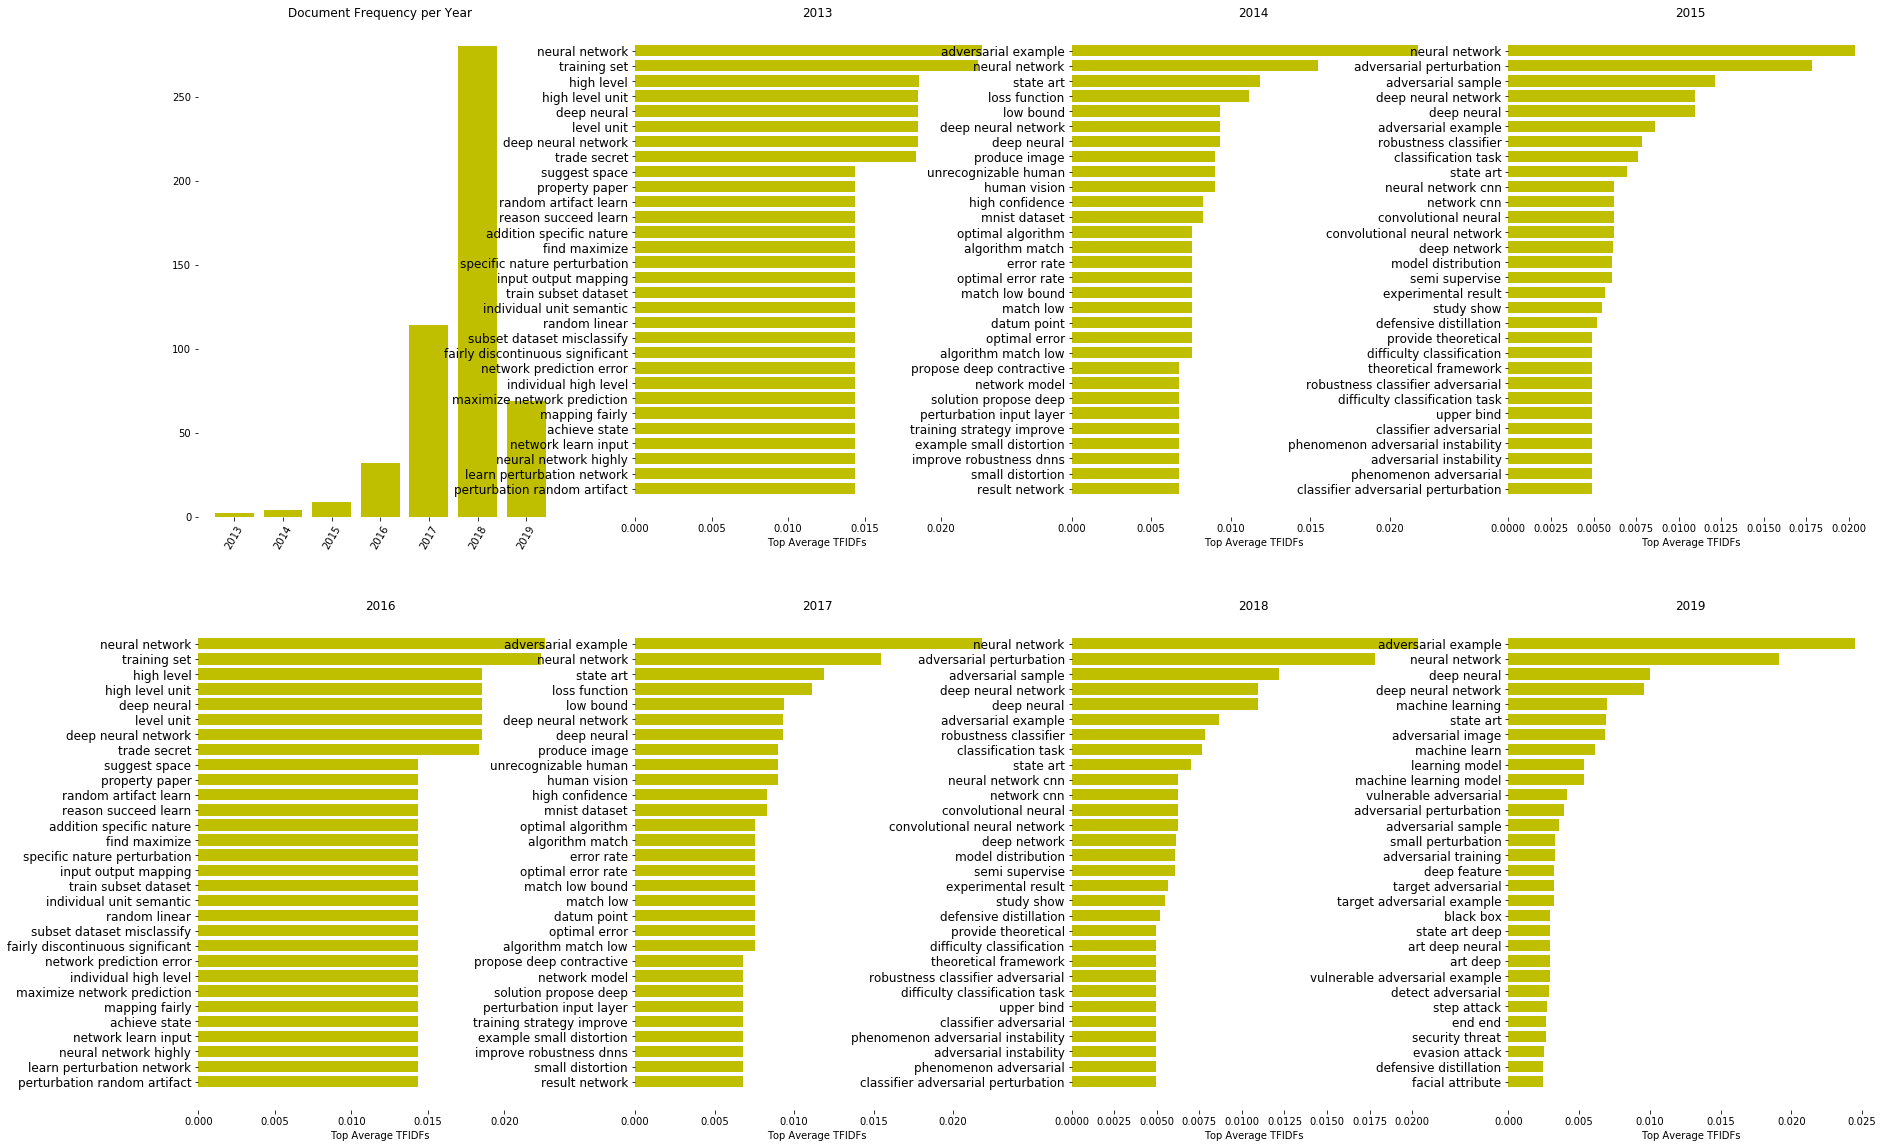

In [193]:
topwords = []
for ik, dtc in enumerate(datetextchunks):
    arxiv_texts_ = [k[0] for k in dtc]
    data_words = list(sent_to_words(arxiv_texts_))
    data_words_nostops = remove_stopwords(data_words)
    data_lemmatized = lemmatization(data_words_nostops, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
    data_lemmatized = [' '.join(k) for k in data_lemmatized]
    counts = CountVectorizer(ngram_range=(2, 3))
    counts.fit(data_lemmatized)
    id2word = {v:k for k, v in counts.vocabulary_.items()}
    x = counts.transform(data_lemmatized)
    rows, cols = x.nonzero()
    vals = [x[r, c] for r, c in zip(rows, cols)]
    uniqrows = np.unique(rows)
    corpus = [[(k, v) for i, k, v in zip(rows, cols, vals) if i == n] for n in uniqrows]
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                               id2word=id2word,
                                               num_topics=5,
                                               random_state=100,
                                               update_every=1,
                                               chunksize=100,
                                               passes=10,
                                               alpha='auto',
                                               per_word_topics=True)
    
    x = lda_model.get_topics()
    words = x.sum(axis=0)
    idxs = np.argsort(words)
    ids = idxs[-30:]
    scores = words[ids]
    topwords.append([(id2word[i], words[i]) for i in ids])
    
f, axarr = plt.subplots(2, 4, figsize=(30,20))
freq = list([len(d) for d in datetextchunks])
freq[-1] -= 2
axarr[0][0].bar(range(2013, 2020), freq, color='y')
axarr[0][0].set_xticks(range(2013, 2020))
axarr[0][0].set_xticklabels([str(k) for k in range(2013, 2020)], rotation=60)
axarr[0][0].set_title('Document Frequency per Year')
axarr[0][0].set_aspect('auto')
axarr[0][0].spines['top'].set_visible(False)
axarr[0][0].spines['right'].set_visible(False)
axarr[0][0].spines['bottom'].set_visible(False)
axarr[0][0].spines['left'].set_visible(False)

for i in range(2013, 2016):
    axarr[0][i-2012].barh(range(0, len(topwords[0])*4, 4), [t[1] for t in topwords[i-2013]], height=3, color='y')
    axarr[0][i-2012].set_yticks(range(0, len(topwords[i-2013])*4, 4))
    axarr[0][i-2012].set_yticklabels([tw[0] for tw in topwords[i-2013]], fontsize=12)
    axarr[0][i-2012].set_aspect('auto')
    axarr[0][i-2012].set_title(str(i))
    axarr[0][i-2012].set_xlabel('Top Average TFIDFs')
    axarr[0][i-2012].spines['top'].set_visible(False)
    axarr[0][i-2012].spines['right'].set_visible(False)
    axarr[0][i-2012].spines['bottom'].set_visible(False)
    axarr[0][i-2012].spines['left'].set_visible(False)
    
for i in range(2016, 2020):
    axarr[1][i-2016].barh(range(0, len(topwords[0])*4, 4), [t[1] for t in topwords[i-2016]], height=3, color='y')
    axarr[1][i-2016].set_yticks(range(0, len(topwords[i-2016])*4, 4))
    axarr[1][i-2016].set_yticklabels([tw[0] for tw in topwords[i-2016]], fontsize=12)
    axarr[1][i-2016].set_aspect('auto')
    axarr[1][i-2016].set_title(str(i))
    axarr[1][i-2016].set_xlabel('Top Average TFIDFs')
    axarr[1][i-2016].spines['top'].set_visible(False)
    axarr[1][i-2016].spines['right'].set_visible(False)
    axarr[1][i-2016].spines['bottom'].set_visible(False)
    axarr[1][i-2016].spines['left'].set_visible(False)

plt.savefig('lda_time.pdf')
plt.show()